In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

In [4]:
raw_train_data=pd.read_csv("dataset/train.csv",sep=",")
raw_test_data=pd.read_csv("dataset/test.csv",sep=",")
train_data=raw_train_data.copy()
train_data["date"]=pd.to_datetime(raw_train_data["date"])
train_data=train_data.set_index("date")
test_data=raw_test_data.copy()
test_data["date"]=pd.to_datetime(raw_test_data["date"])
test_data=test_data.set_index("date")
train_data.head()

,substation,consumption
date,,
2018-01-01 00:00:00,AJAHUEL,137.330840
2018-01-01 01:00:00,AJAHUEL,124.045549
2018-01-01 02:00:00,AJAHUEL,118.137811
2018-01-01 03:00:00,AJAHUEL,107.899499
2018-01-01 04:00:00,AJAHUEL,100.362069


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244391 entries, 2018-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   substation   244391 non-null  object 
 1   consumption  244391 non-null  float64
dtypes: float64(1), object(1)
memory usage: 5.6+ MB
Data Quality:
substation     0
consumption    0
dtype: int64

Data Distribution:
         consumption
count  244391.000000
mean      179.548024
std       156.018729
min      -199.000000
25%         0.181926
50%       172.099977
75%       262.179646
max       752.006309

Data Visualization:


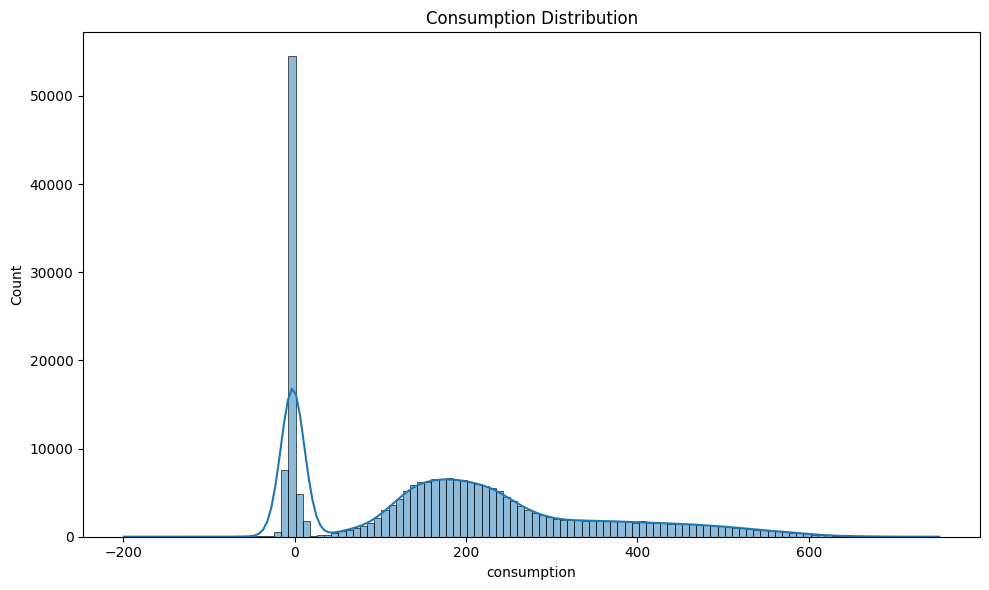

In [5]:
from sklearn.preprocessing import StandardScaler

train_data.info()
# Data quality
print("Data Quality:")
print(train_data.isnull().sum())

# Data distribution
print("\nData Distribution:")   
print(train_data.describe())

# Data visualization
print("\nData Visualization:")
plt.figure(figsize=(10, 6))
sns.histplot(train_data['consumption'], kde=True)
plt.title('Consumption Distribution')
plt.tight_layout()
plt.savefig('figures/consumption_distribution.png')
plt.show()

In [6]:
train_data.describe()


,consumption
count,244391.000000
mean,179.548024
std,156.018729
min,-199.000000
25%,0.181926
50%,172.099977
75%,262.179646
max,752.006309


In [7]:
# Get the list of substations
substations = train_data['substation'].unique()

adf = []
for i, substation in enumerate(substations):
    subset = train_data[train_data['substation'] == substation]
    description = subset['consumption'].describe()
    adf.append({ "substation": substation, "min": description["min"], "max": description["max"], "mean": description["mean"], "std": description["std"], "count": description["count"] })
pd.DataFrame(adf).drop('count', axis=1).to_latex("tables/substations.tex", caption="Substations statistics", index = False)

The minimum value from the BUIN substation of -199 skews the data. It looks like a measure error. By now, we'll leave it out and replace using 0's.

In [8]:
# Reemplazar valores de consumo en subestación BUIN.
train_data.loc[(train_data['substation'] == 'BUIN') & (train_data['consumption'] == -199.0), 'consumption'] = 0
train_data.loc[(train_data['substation'] == 'BUIN') & (train_data['consumption'] > 0), 'consumption'] = 0


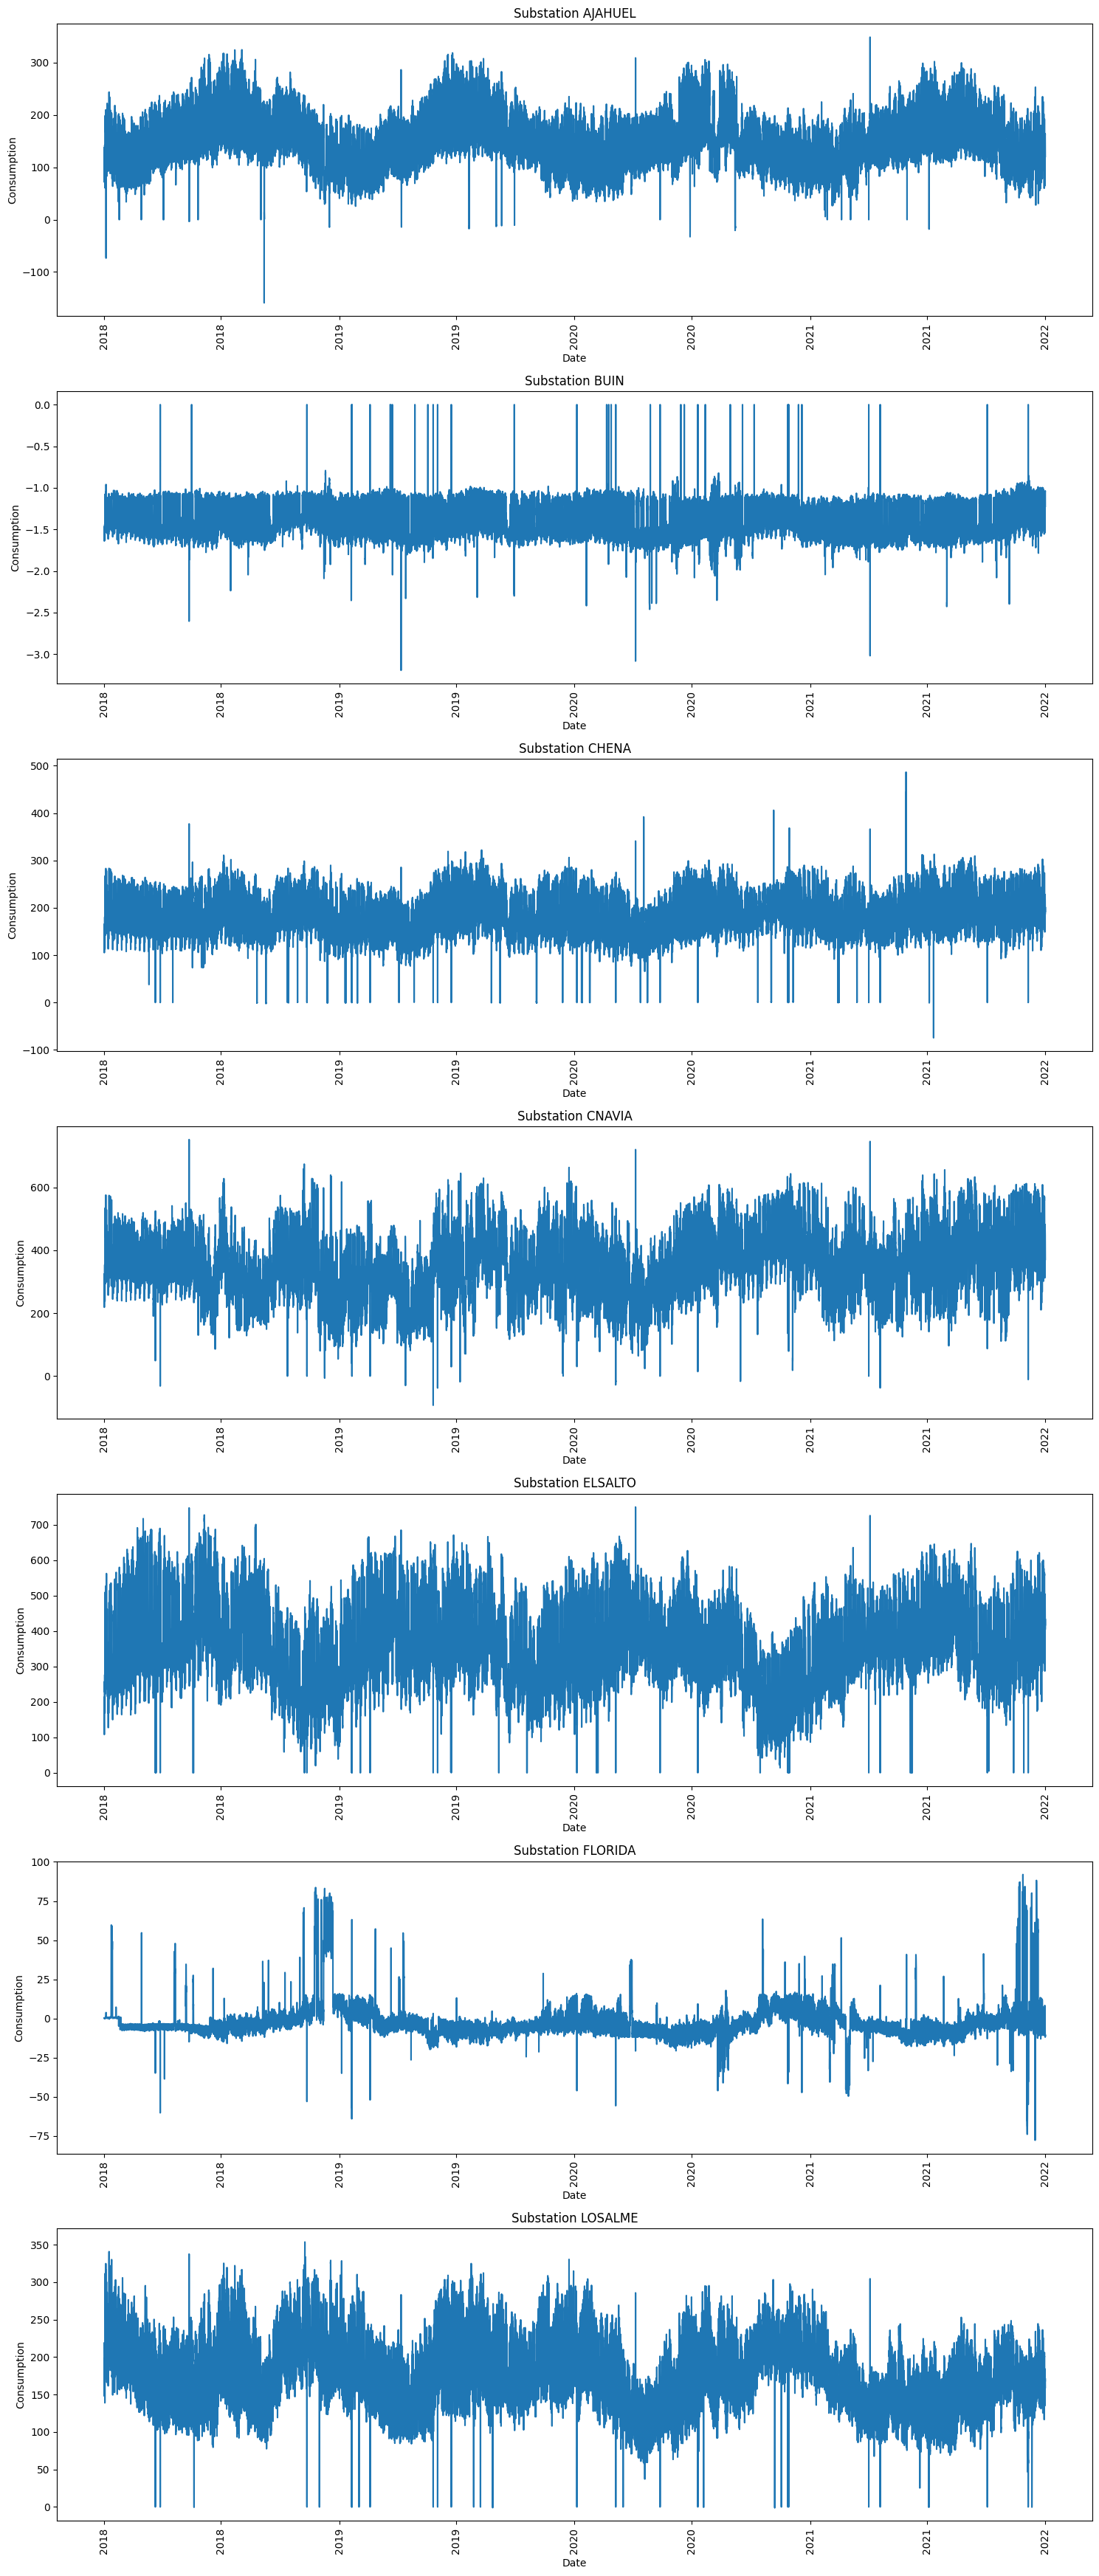

In [9]:
# plotear los datos separados por subestacion
from matplotlib.dates import DateFormatter
import math

# Definir el número de filas y columnas para los subplots
n_cols = 1
n_rows = math.ceil(len(substations) / n_cols)  # Calcular el número de filas necesarias

# Crear una figura y subplots (organizados en una cuadrícula de 2 columnas)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Aplanar el arreglo de axes si es necesario para facilitar la iteración
axes = axes.flatten()

# Iterar sobre las subestaciones y sus correspondientes subplots
for i, substation in enumerate(substations):
    subset = train_data[train_data['substation'] == substation]
    ax = axes[i]
    ax.plot(subset['consumption'])
    ax.set_title(f'Substation {substation}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Consumption')
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))  # Formatear para mostrar solo el año
    ax.tick_params(axis='x', rotation=90)  # Rotar etiquetas del eje x

# Eliminar subplots vacíos si el número de subestaciones no es múltiplo de 2
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar espacio entre subplots para evitar solapamiento
plt.tight_layout()

plt.savefig("figures/consumption_by_substation.png")
# Mostrar el gráfico
plt.show()


Let's explore alternatives to model patterns for the time series by removing outliers and detect seasonality.
1. Rolling Z-score Method for Time Series
In this method, we'll compute the Z-score over a rolling window to identify outliers relative to the local statistics of the series.
A rolling window approach helps in keeping track of local changes in the time series. The Z-score is computed over a window (e.g., 7 days) to adjust for local variations, thus identifying outliers dynamically as the time series evolves. In this series, the granularity is 15 min (4 samples per hour), so the time window will represent 15 min. intervals.

* Barnett, V., & Lewis, T. (1994). Outliers in Statistical Data (3rd ed.). Wiley.
This book provides a foundational understanding of outliers and their detection using statistical methods like Z-scores.
* Hyndman, R. J., & Athanasopoulos, G. (2018). Forecasting: principles and practice (2nd ed.). OTexts.
This open-source textbook discusses outlier detection in time series, including Z-scores in the context of forecasting.

In [10]:
def zscore(s, window, thresh=3, return_all=False):
    roll = s.rolling(window=window, min_periods=1, center=True)
    avg = roll.mean()
    std = roll.std(ddof=0)
    z = s.sub(avg).div(std)   
    m = z.between(-thresh, thresh)
    
    if return_all:
        return z, avg, std, m
    return s.where(m, avg)

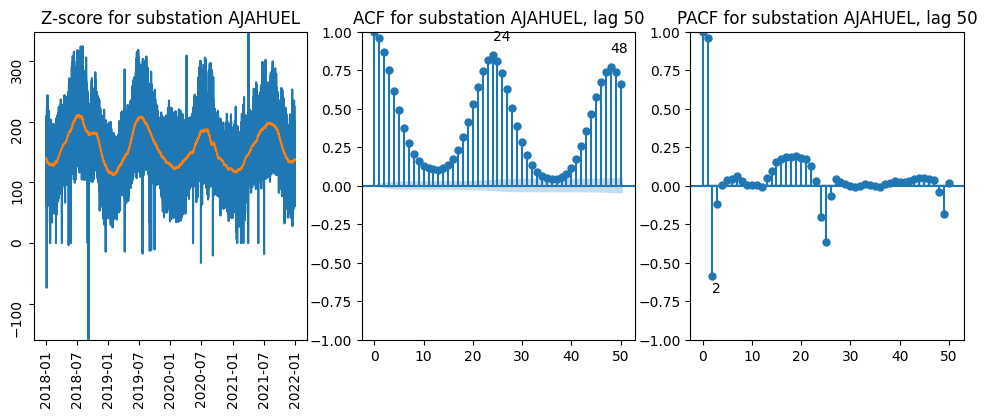

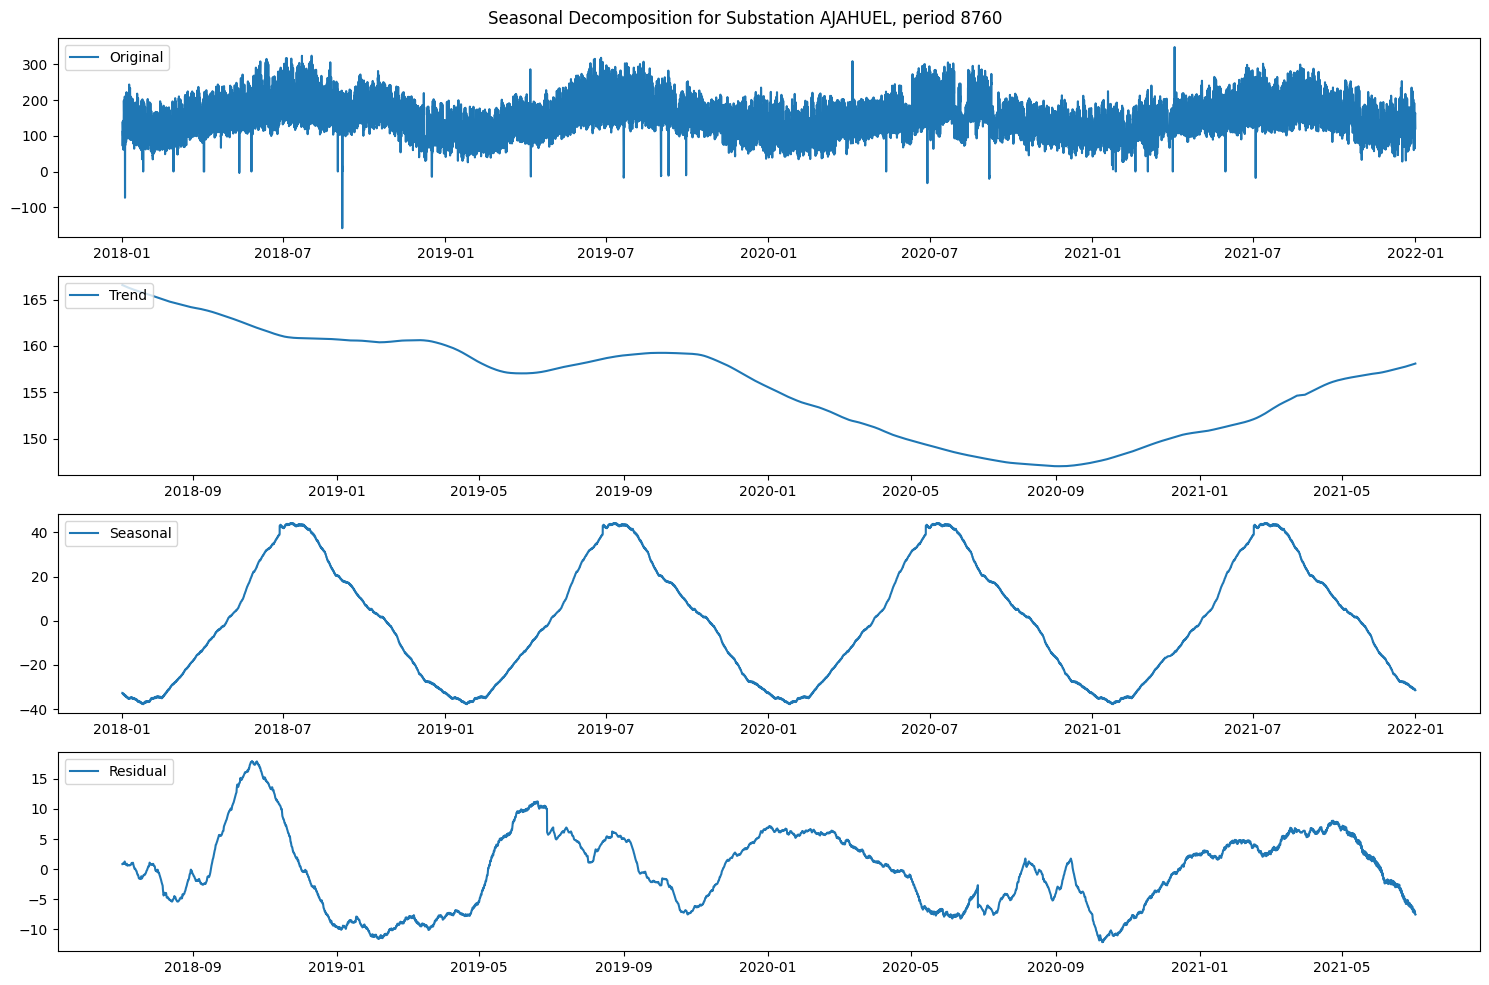

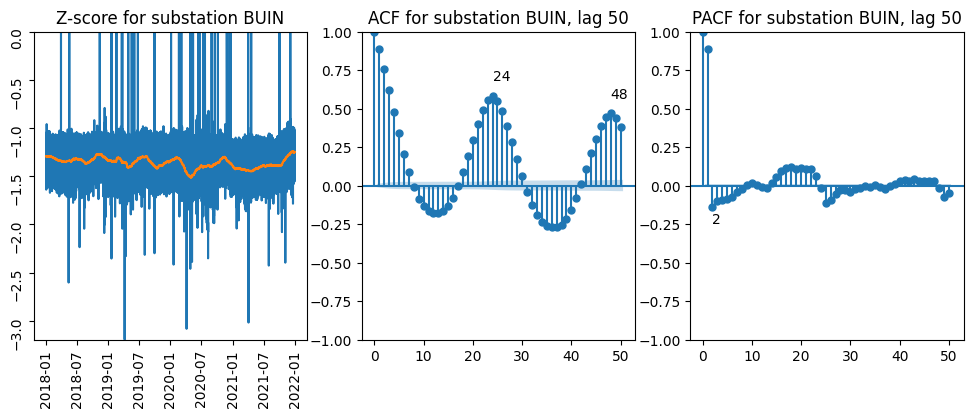

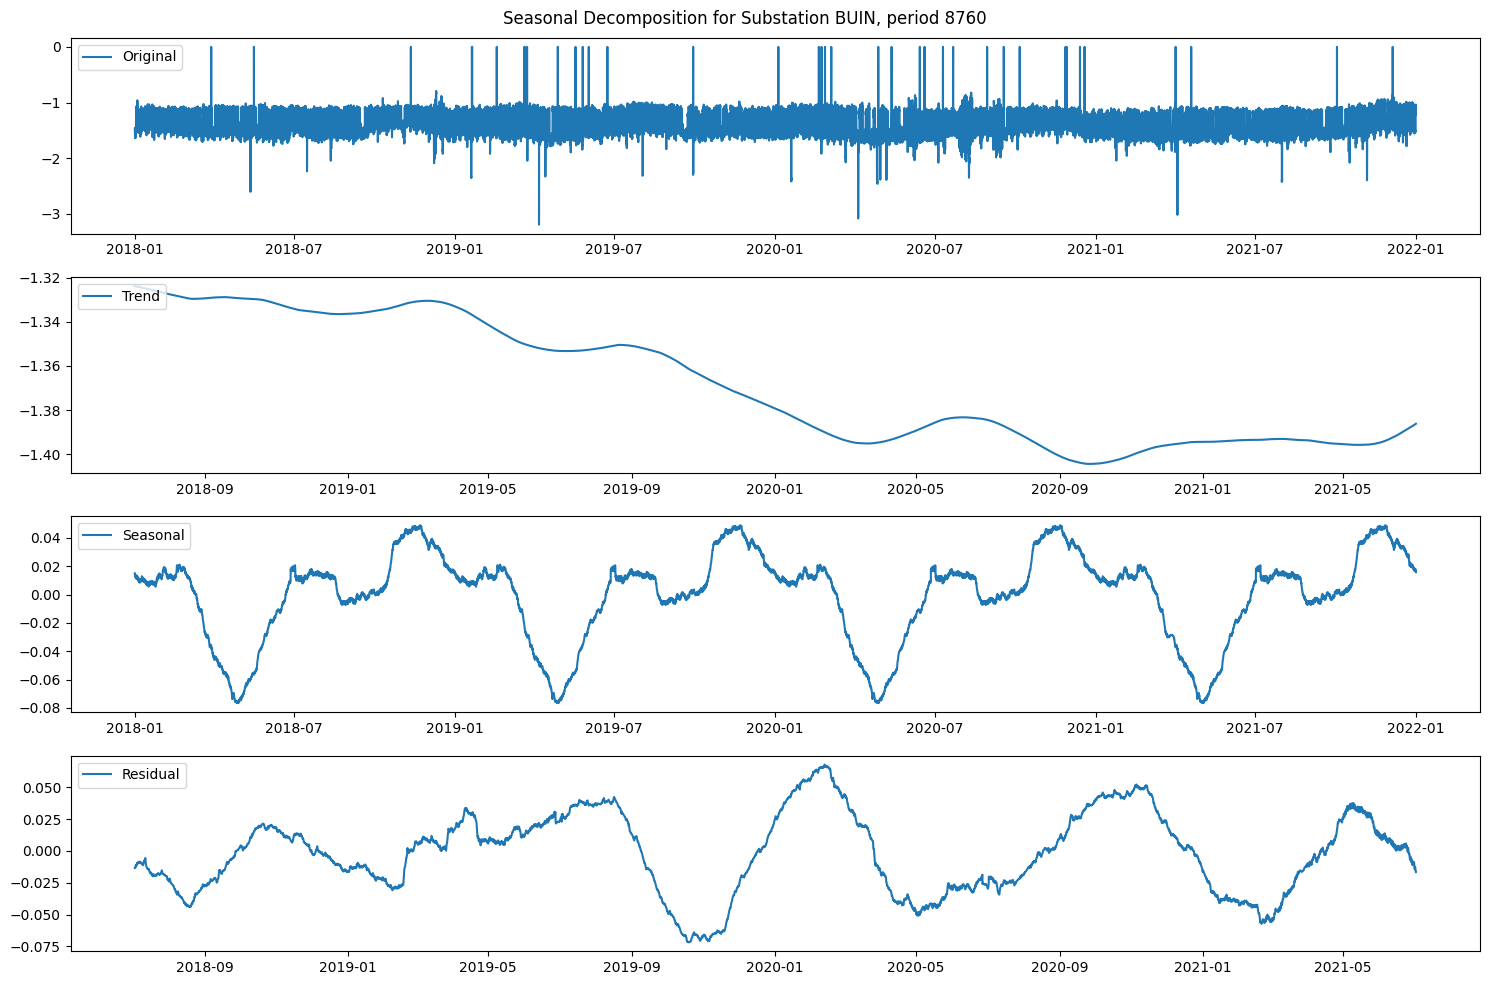

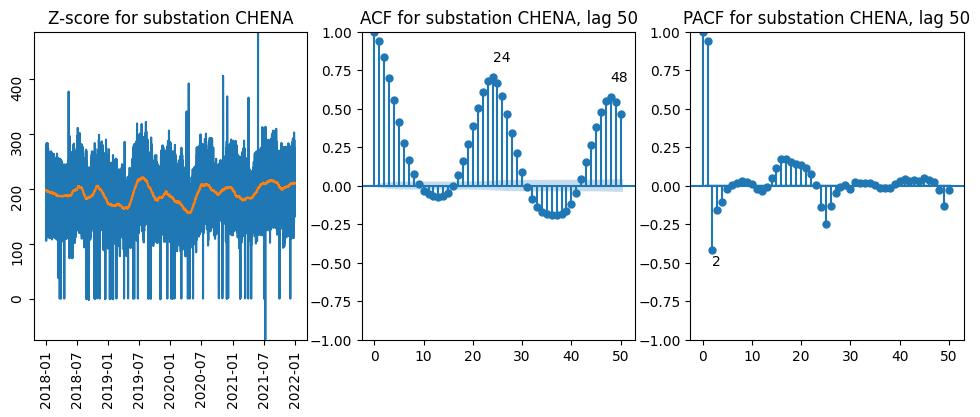

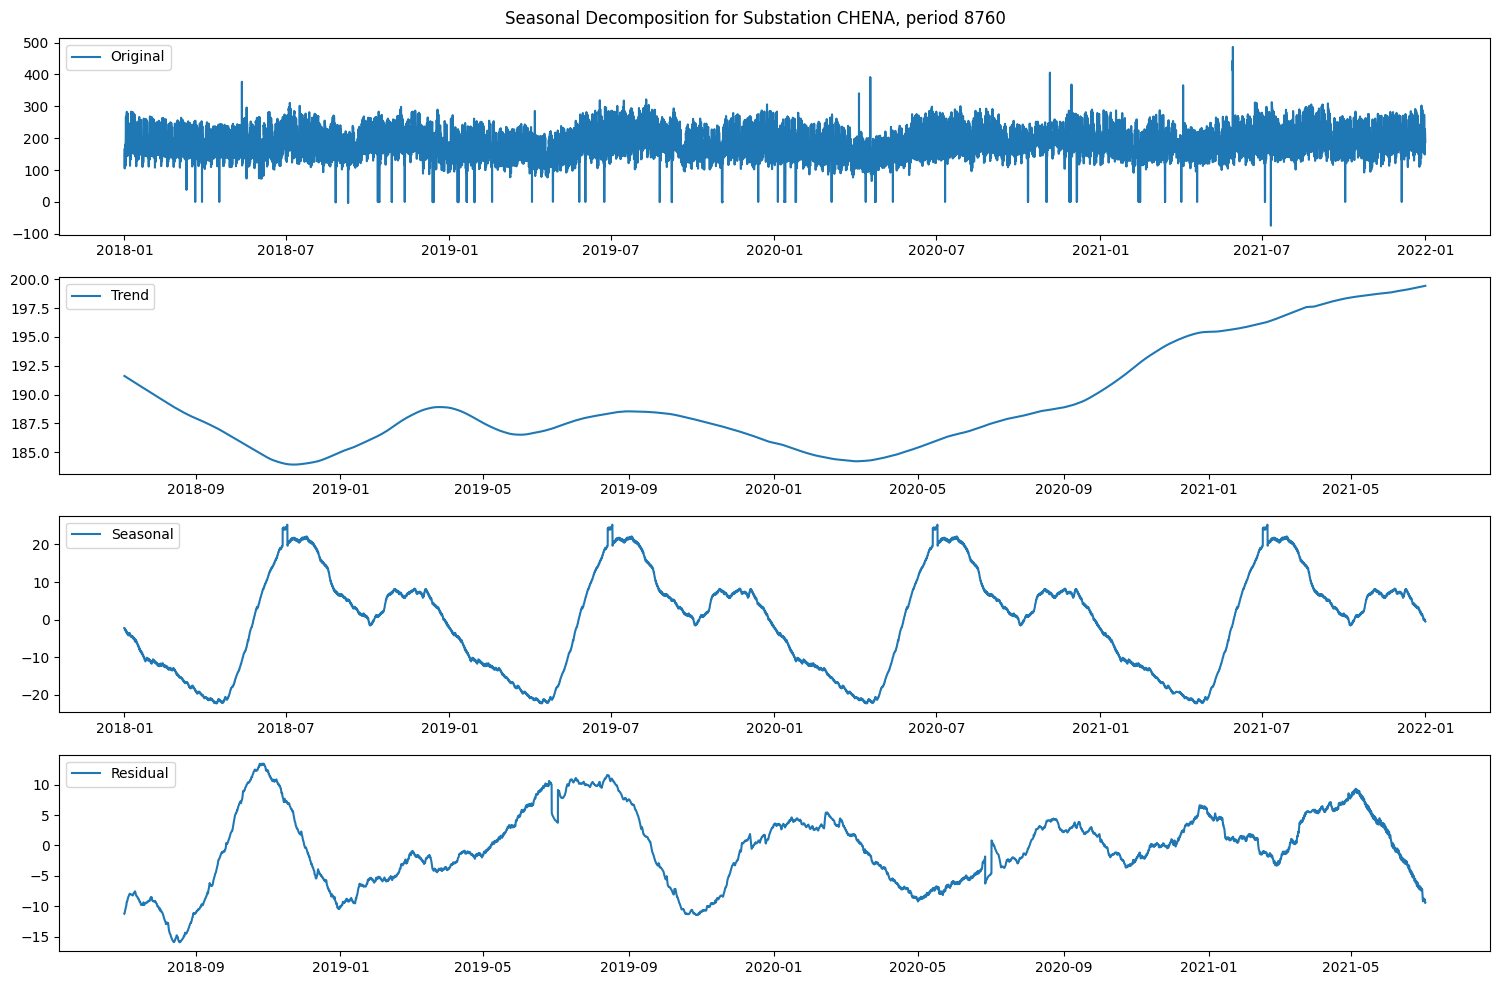

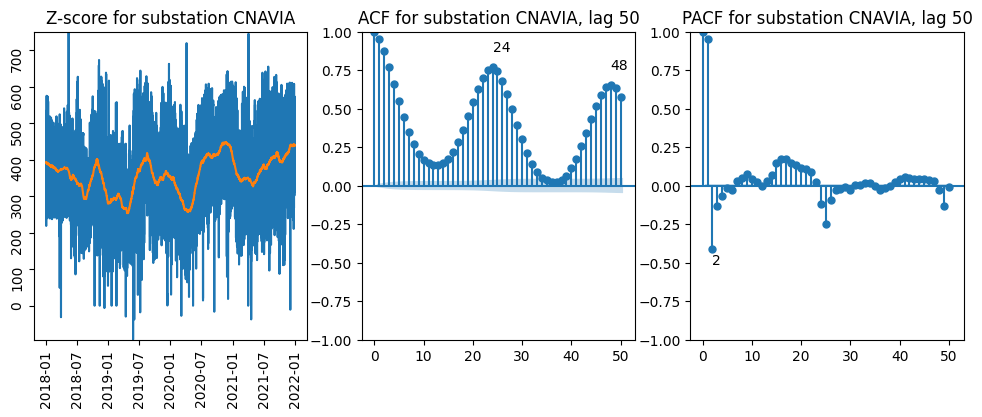

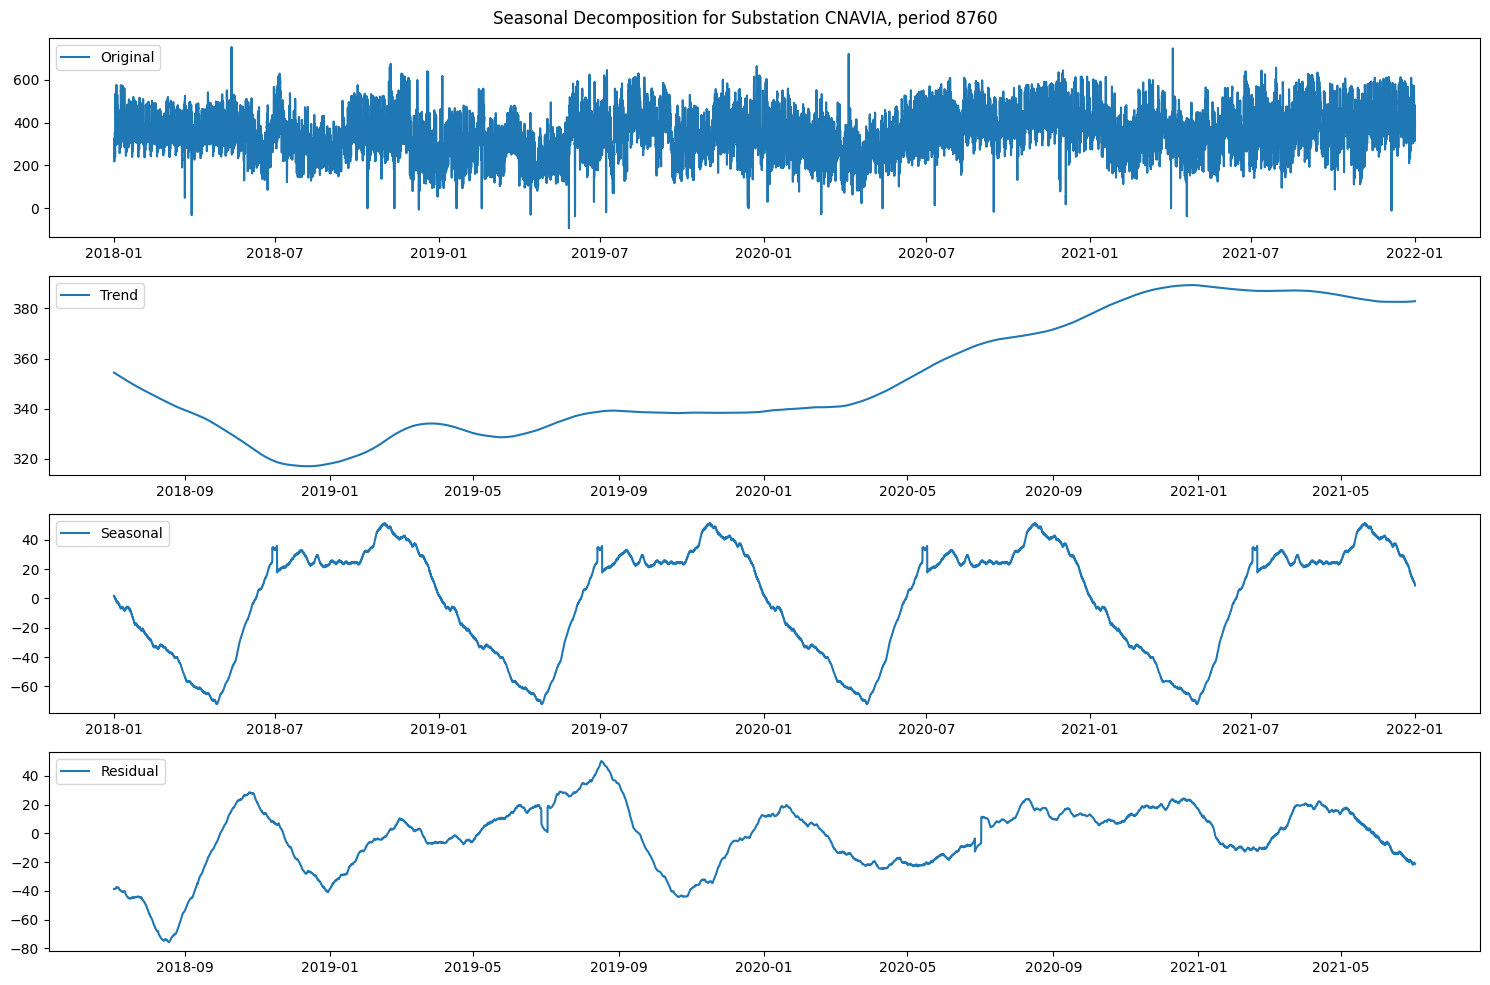

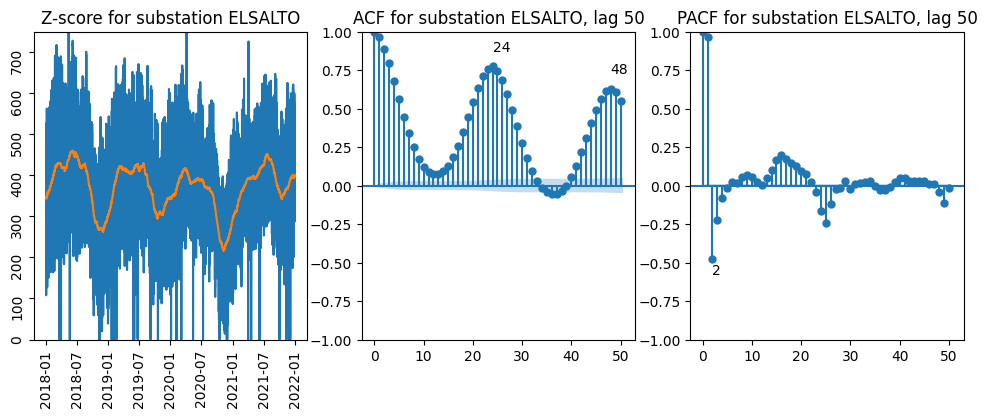

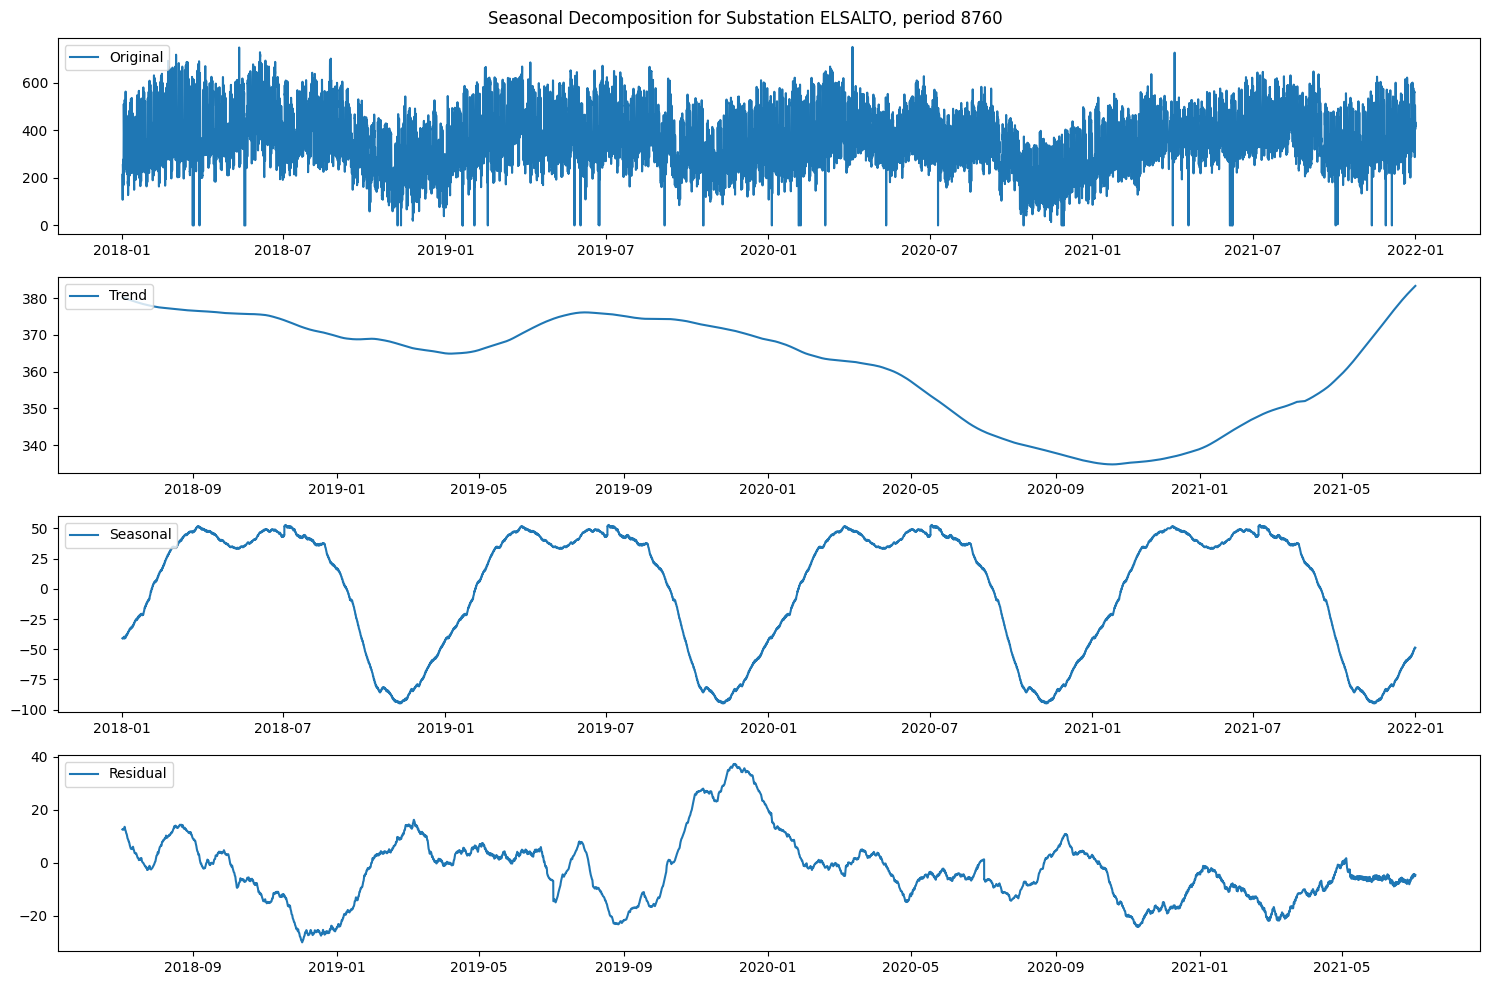

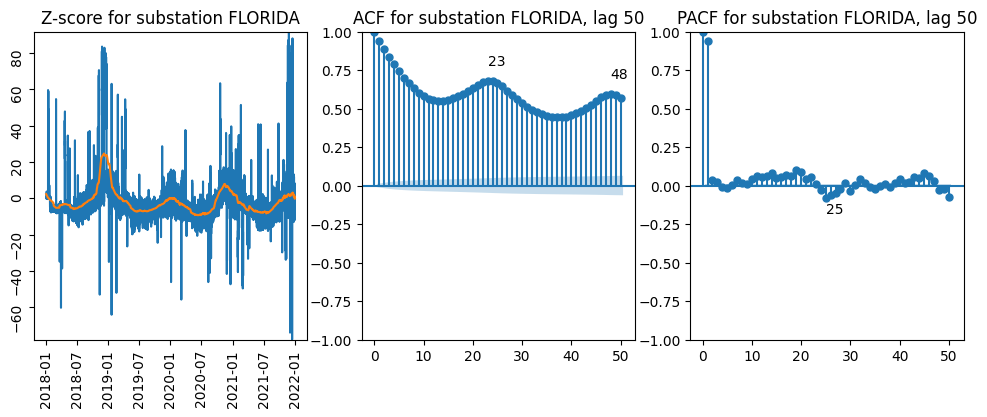

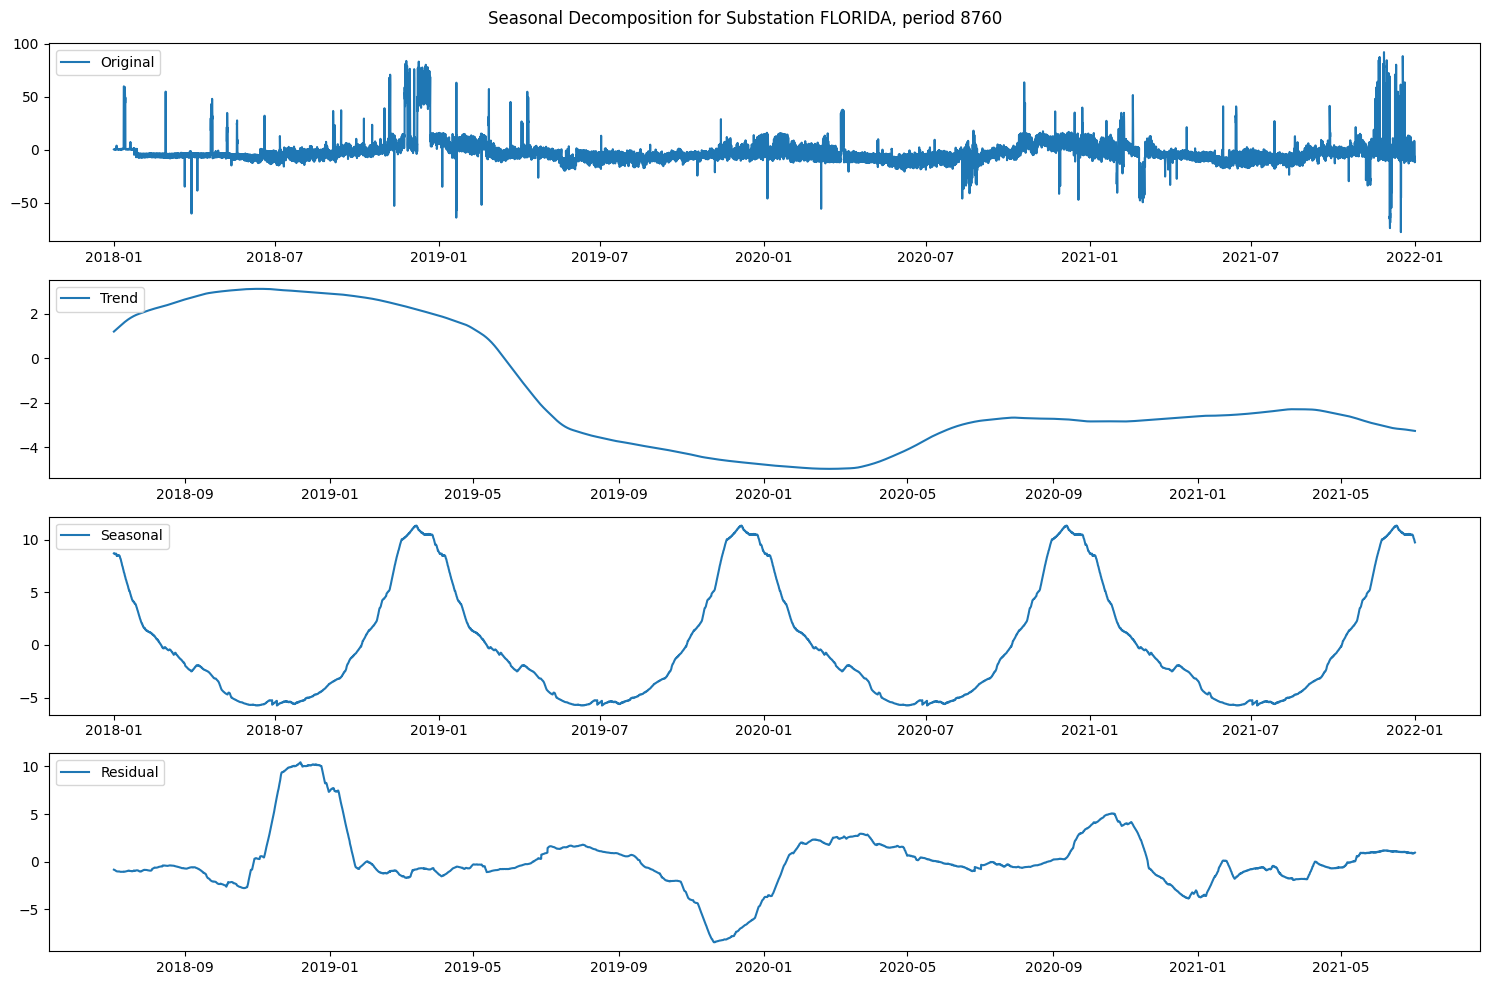

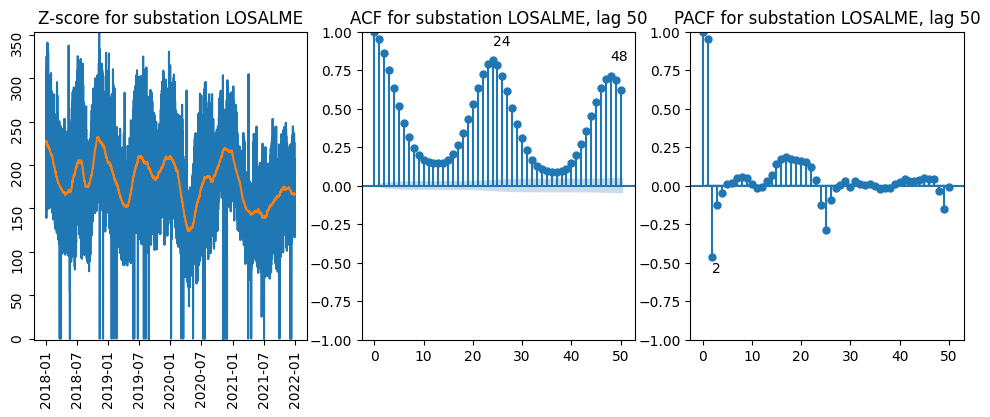

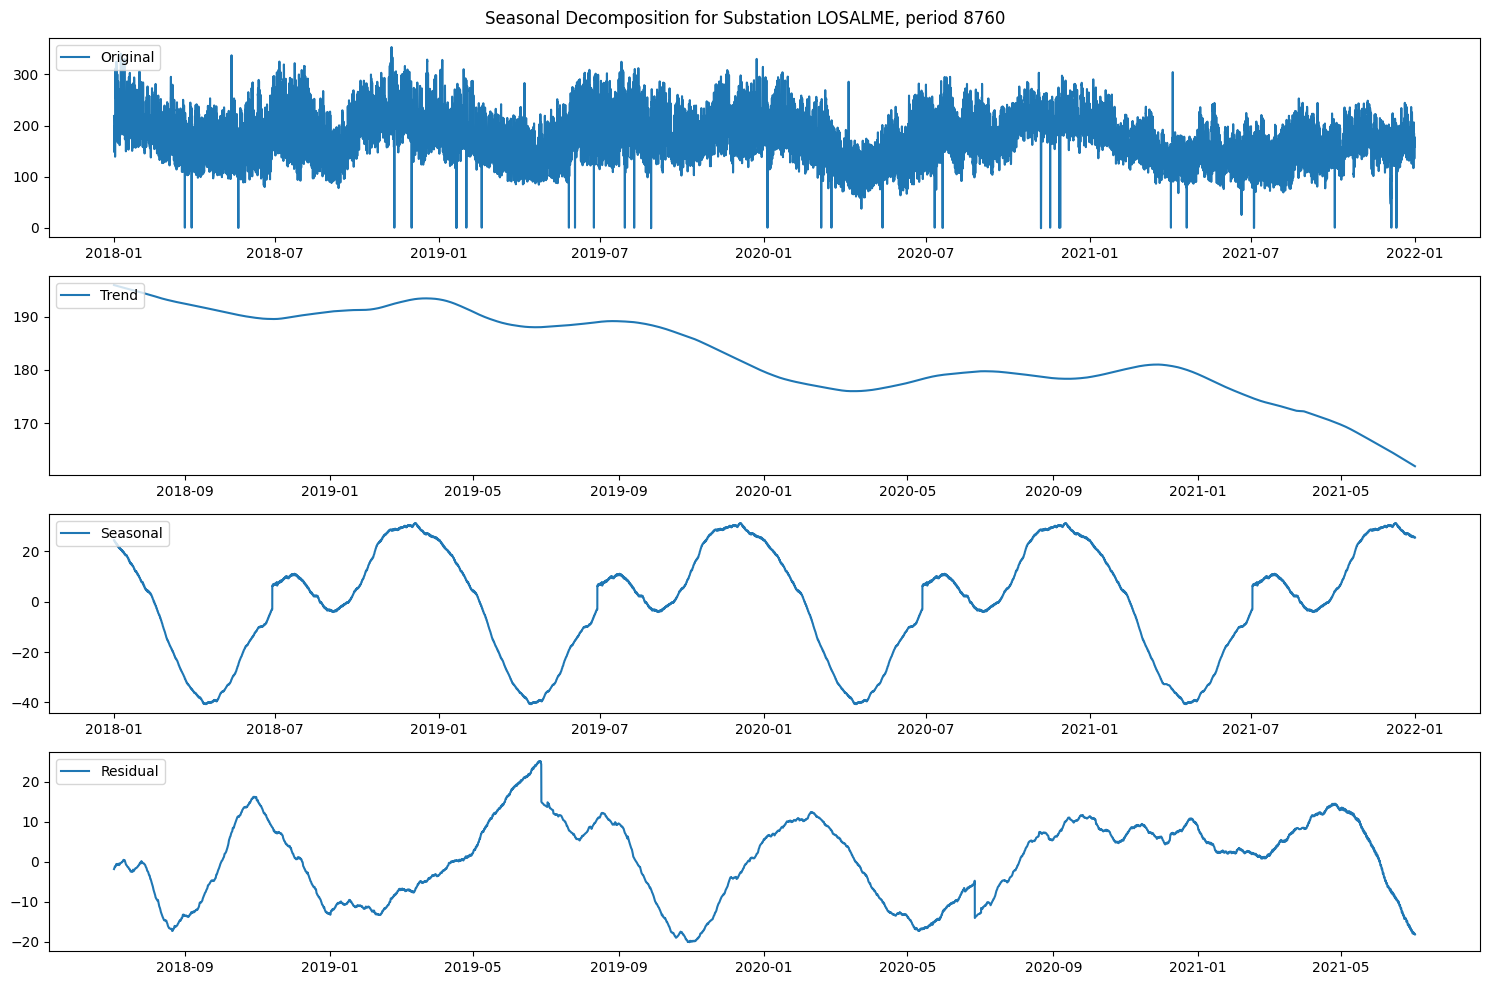

,substation,lag,window,p-value
0,AJAHUEL,50,1500,1.078609e-18
1,BUIN,50,1500,0.000000e+00
2,CHENA,50,1500,2.097382e-30
3,CNAVIA,50,1500,4.082258e-24
4,ELSALTO,50,1500,7.338061e-28
5,FLORIDA,50,1500,1.408109e-18
6,LOSALME,50,1500,9.093989e-21


In [11]:
import numpy as np
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose 
from scipy.signal import find_peaks
np.random.seed(1)
adf = []
for substation in substations:
    train_subset = train_data[train_data['substation'] == substation]
    lags = [50]
    for lag in lags:
        windows = [1500]
        df = train_subset.copy()
        for window in windows:
            y=train_subset["consumption"]
            z, avg, std, m = zscore(y, window=window, return_all=True)
            fig, axes=plt.subplots(1,3)
            fig.set_size_inches(12,4)
            axes[0].plot(train_subset.index,y)
            min_y = y.min()
            max_y = y.max()
            axes[0].plot(train_subset.index,avg)
            axes[0].tick_params(labelrotation=90)
            axes[0].set_title(f"Z-score for substation {substation}")
            axes[0].set_ylim(min_y, max_y)
            acf_points = acf(y, nlags=lag)
            acf_peaks, _ = find_peaks(acf_points, height=0.1)
            plot_acf(y,lags=lag,ax=axes[1], title=f"ACF for substation {substation}, lag {lag}");
            for peak in acf_peaks:
                axes[1].annotate(f'{peak}', xy=(peak, acf_points[peak]), xytext=(peak, acf_points[peak] + 0.1))
            pacf_points = pacf(y, nlags=lag)
            xmin = np.argmin(pacf_points)
            ymin = pacf_points[xmin]
            plot_pacf(y,lags=lag,ax=axes[2], title=f"PACF for substation {substation}, lag {lag}", use_vlines=True);
            axes[2].annotate(f'{xmin}', xy=(xmin, ymin), xytext=(xmin, ymin - 0.1))
            fig.savefig(f"figures/zscore_{substation}_{lag}.pdf")
            for period in [8760]:
                decomposition = seasonal_decompose(avg, model='additive', period=period)  # Assuming yearly seasonality with 1-hour intervals (24 intervals per day * 365 days)
                fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))
                fig.suptitle(f'Seasonal Decomposition for Substation {substation}, period {period}')
                
                ax1.plot(y, label='Original')
                ax1.legend(loc='upper left')
                
                ax2.plot(decomposition.trend, label='Trend')
                ax2.legend(loc='upper left')
                
                ax3.plot(decomposition.seasonal, label='Seasonal')
                ax3.legend(loc='upper left')
                
                ax4.plot(decomposition.resid, label='Residual')
                ax4.legend(loc='upper left')
                
                plt.tight_layout()
                plt.show()
                fig.savefig(f"figures/decomposition_{substation}_{lag}_{period}.pdf")

        result = adfuller(y,maxlag=lag)
        adf.append({"substation":substation, "lag": lag, "window":window,"p-value":result[1]})
pd.DataFrame(adf).to_markdown("tables/adf.md", index=False)
pd.DataFrame(adf)



In [12]:
from statsmodels.tsa.arima.model import ARIMA
correlations = [{"acf": 2, "order": 0, "pacf": 2}, {"acf": 24, "order": 0, "pacf": 24}]
arima_runs = []
for substation in substations:
    train_subset = train_data[train_data['substation'] == substation]
    test_subset = test_data[test_data['substation'] == substation]
    y_train=train_subset["consumption"].to_numpy()
    y_test=test_subset["consumption"].to_numpy()
    for correlation in correlations:
        modelo=ARIMA(y_train,order=(correlation["acf"],correlation["order"],correlation["pacf"]))
        predictor=modelo.fit()
        arima_runs.append({"substation":substation, "correlation": correlation, "aic":predictor.aic, "bic":predictor.bic, "hqic":predictor.hqic, "mse":predictor.mse})
        predictor.save(f"models/arima_{substation}_{correlation['acf']}_{correlation['order']}_{correlation['pacf']}.pkl")
pd.DataFrame(arima_runs)

NameError: name 'substations_group1' is not defined

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_results = []

for substation in substations:
    subset = train_data[train_data['substation'] == substation]
    decomposition = seasonal_decompose(subset['consumption'], model='additive', period=5000)  # Assuming daily seasonality with 15-min intervals (96 intervals per day)
    
    seasonal_results.append({
        "substation": substation,
        "trend": decomposition.trend,
        "seasonal": decomposition.seasonal,
        "resid": decomposition.resid
    })
    
    # Plot the decomposition
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))
    fig.suptitle(f'Seasonal Decomposition for Substation {substation}')
    
    ax1.plot(subset['consumption'], label='Original')
    ax1.legend(loc='upper left')
    
    ax2.plot(decomposition.trend, label='Trend')
    ax2.legend(loc='upper left')
    
    ax3.plot(decomposition.seasonal, label='Seasonal')
    ax3.legend(loc='upper left')
    
    ax4.plot(decomposition.resid, label='Residual')
    ax4.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Save the seasonal results to a markdown file
seasonal_df = pd.DataFrame(seasonal_results)
seasonal_df.to_markdown("tables/seasonal_decomposition.md", index=False)
seasonal_df